In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel("/home/margaux/code/projet-final/data/online_retail_II.xlsx")

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [12]:
print(df.columns)

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


In [13]:
df = df.dropna(subset=["Customer ID"])

df = df[~df["Invoice"].astype(str).str.startswith("C")]

df["TotalPrice"] = df["Quantity"] * df["Price"]

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


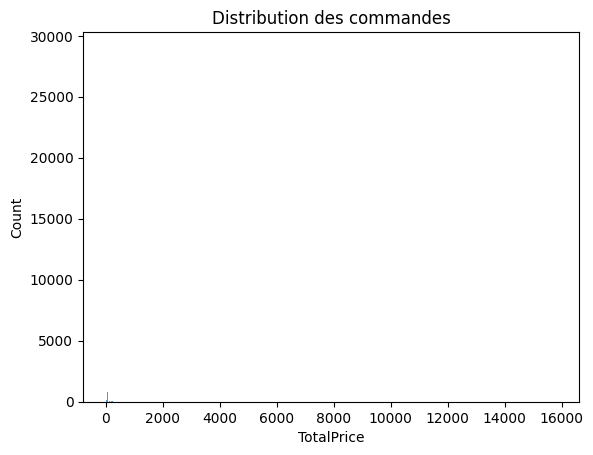

In [15]:
plt.figure()
sns.histplot(df["TotalPrice"])
plt.title("Distribution des commandes")
plt.show()

/tmp/ipykernel_1758/3461398915.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df.set_index("InvoiceDate").resample("M")["TotalPrice"].sum()


<Axes: title={'center': 'Revenue mensuel'}, xlabel='InvoiceDate'>

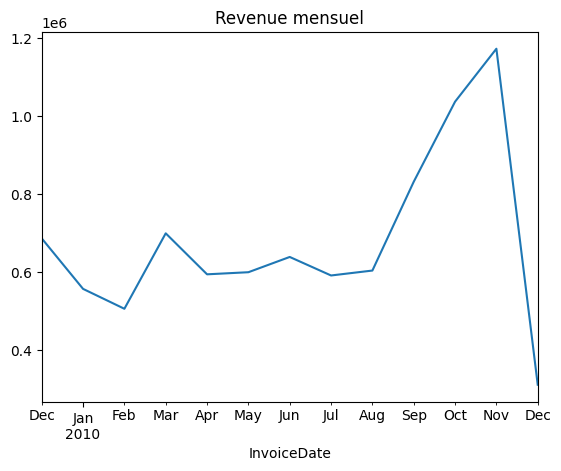

In [16]:
ts = df.set_index("InvoiceDate").resample("M")["TotalPrice"].sum()
ts.plot(title="Revenue mensuel")

In [18]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortMonth'] = df.groupby('Customer ID')['InvoiceMonth'].transform('min')
cohorts = df.groupby(['CohortMonth','InvoiceMonth'])['Customer ID'].nunique().unstack()
cohorts

InvoiceMonth,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12
CohortMonth,,,,,,,,,,,,,
2009-12,955.0,337.0,319.0,406.0,363.0,343.0,360.0,327.0,321.0,346.0,403.0,473.0,237.0
2010-01,NaN,383.0,79.0,119.0,117.0,101.0,115.0,99.0,88.0,107.0,122.0,116.0,38.0
2010-02,NaN,NaN,376.0,89.0,84.0,109.0,92.0,75.0,72.0,107.0,95.0,103.0,27.0
2010-03,NaN,NaN,NaN,443.0,84.0,102.0,107.0,103.0,90.0,109.0,134.0,122.0,35.0
2010-04,NaN,NaN,NaN,NaN,294.0,57.0,57.0,48.0,54.0,66.0,81.0,77.0,20.0
2010-05,NaN,NaN,NaN,NaN,NaN,254.0,40.0,43.0,44.0,45.0,65.0,54.0,20.0
2010-06,NaN,NaN,NaN,NaN,NaN,NaN,270.0,47.0,51.0,55.0,62.0,77.0,18.0
2010-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186.0,29.0,34.0,55.0,54.0,19.0
2010-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.0,33.0,48.0,52.0,19.0


In [19]:
print("Doublons :", df.duplicated().sum())
df = df.drop_duplicates()

Doublons : 6748


In [20]:
print("Quantités négatives :", (df['Quantity'] < 0).sum())
print("Prix négatifs :", (df['Price'] < 0).sum())

df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]


Quantités négatives : 0
Prix négatifs : 0


In [21]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})
rfm.rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalPrice': 'Monetary'}, inplace=True)
rfm.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93


In [22]:
quantiles = rfm.quantile(q=[0.25,0.5,0.75]).to_dict()

def r_score(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

def fm_score(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

rfm['R'] = rfm['Recency'].apply(r_score, args=('Recency',quantiles))
rfm['F'] = rfm['Frequency'].apply(fm_score, args=('Frequency',quantiles))
rfm['M'] = rfm['Monetary'].apply(fm_score, args=('Monetary',quantiles))
rfm['RFM_Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()


,Recency,Frequency,Monetary,R,F,M,RFM_Score
Customer ID,,,,,,,
12346.0,165,11,372.86,1,4,2,142
12347.0,3,2,1323.32,4,2,3,423
12348.0,74,1,222.16,2,1,1,211
12349.0,43,3,2671.14,3,3,4,334
12351.0,11,1,300.93,4,1,1,411


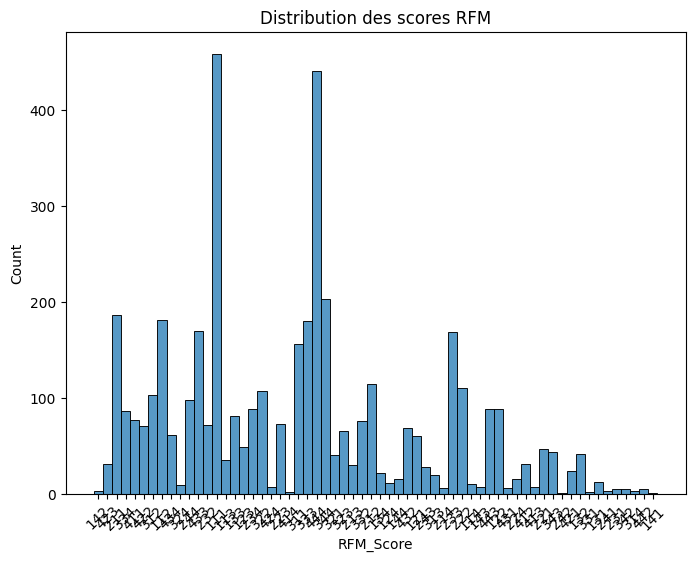

In [23]:
plt.figure(figsize=(8,6))
sns.histplot(rfm['RFM_Score'], bins=20)
plt.title("Distribution des scores RFM")
plt.xticks(rotation=45)
plt.show()


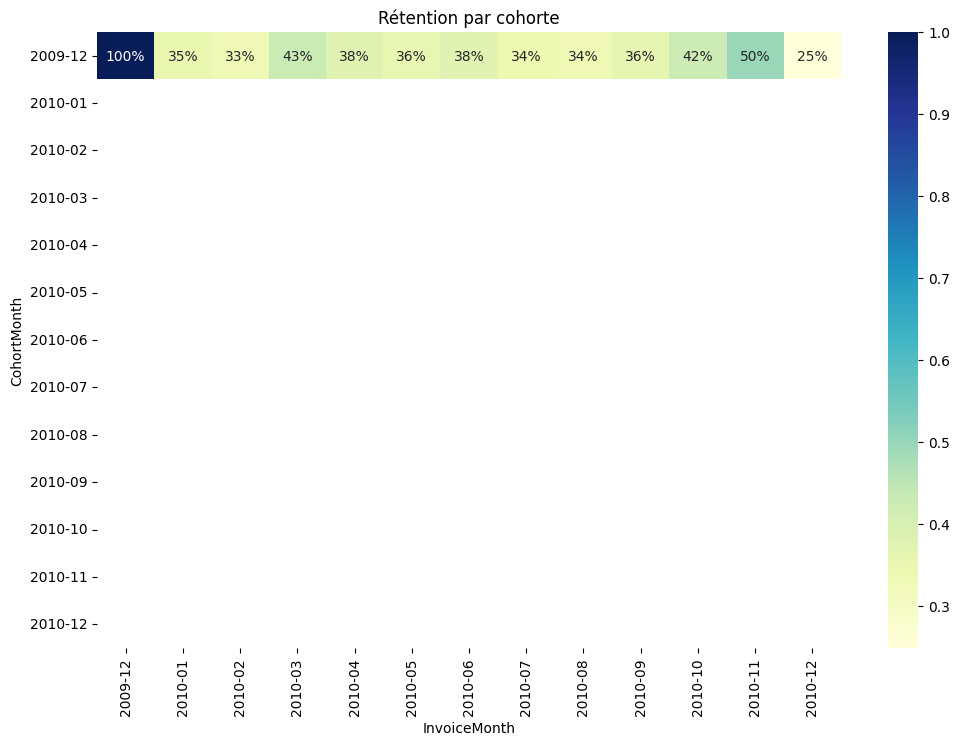

In [24]:
cohort_sizes = cohorts
retention = cohort_sizes.divide(cohort_sizes.iloc[:,0], axis=0)
plt.figure(figsize=(12,8))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title("Rétention par cohorte")
plt.show()

In [25]:
# Clients par pays
df['Country'].value_counts().head(10)

# CA par pays
df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)

# CA total, moyenne par commande, etc.
print("CA total :", df['TotalPrice'].sum())
print("Panier moyen :", df['TotalPrice'].mean())


CA total : 8798233.743999999
Panier moyen : 21.94532955531832


In [26]:
# Créer le dossier processed si ce n'est pas déjà fait
import os
os.makedirs("/home/margaux/code/projet-final/data/processed", exist_ok=True)

# Enregistrer le DataFrame nettoyé
processed_path = "/home/margaux/code/projet-final/data/processed/online_retail_II_cleaned.csv"
df.to_csv(processed_path, index=False, encoding='utf-8')
print(f"Données nettoyées sauvegardées dans : {processed_path}")


Données nettoyées sauvegardées dans : /home/margaux/code/projet-final/data/processed/online_retail_II_cleaned.csv


In [4]:
"""
Script pour préparer les données Online Retail
"""

import pandas as pd
import numpy as np
from pathlib import Path

def prepare_data(input_path, output_path):
    """Charge et nettoie les données"""
    print("Chargement des données...")
    
    # Charger
    if input_path.endswith('.xlsx'):
        df = pd.read_excel(input_path)
    else:
        df = pd.read_csv(input_path, encoding='utf-8')
    
    print(f"Lignes chargées: {len(df):,}")
    print(f"Colonnes: {list(df.columns)}")
    
    print("\nNettoyage...")
    
    # Stats avant nettoyage
    print(f"Lignes initiales: {len(df):,}")
    print(f"Customer ID manquants: {df['Customer ID'].isna().sum():,}")
    
    # Nettoyer les colonnes
    df.columns = df.columns.str.strip()
    
    # Supprimer les lignes sans Customer ID
    df = df.dropna(subset=['Customer ID'])
    print(f"Après suppression NaN: {len(df):,} lignes")
    
    # Convertir Customer ID en entier
    df['Customer ID'] = df['Customer ID'].astype(int)
    
    # Convertir la date
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    
    # Identifier les retours
    df['IsReturn'] = df['Invoice'].astype(str).str.startswith('C')
    print(f"Retours identifiés: {df['IsReturn'].sum():,} lignes")
    
    # Calculer le montant
    df['Amount'] = df['Quantity'] * df['Price']
    
    # Stats
    print("\nStatistiques:")
    print(f"Montant min: £{df['Amount'].min():.2f}")
    print(f"Montant max: £{df['Amount'].max():.2f}")
    print(f"Montant moyen: £{df['Amount'].mean():.2f}")
    
    # Trier par date
    df = df.sort_values('InvoiceDate')
    
    # Infos finales
    print("\nDonnées nettoyées:")
    print(f"Lignes finales: {len(df):,}")
    print(f"Clients uniques: {df['Customer ID'].nunique():,}")
    print(f"Période: {df['InvoiceDate'].min().date()} à {df['InvoiceDate'].max().date()}")
    print(f"Pays: {df['Country'].nunique()}")
    print(f"CA total: £{df[~df['IsReturn']]['Amount'].sum():,.2f}")
    
    # Sauvegarder
    print(f"\nSauvegarde vers {output_path}...")
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    df.to_csv(output_path, index=False)
    print(f"Fichier sauvegardé")
    
    return df

if __name__ == "__main__":
    INPUT_FILE = "/home/margaux/code/projet-final/data/online_retail_II.xlsx"
    OUTPUT_FILE = "data/processed/online_retail_clean.csv"
    
    print("PRÉPARATION DES DONNÉES")
    print("="*60)
    
    try:
        df = prepare_data(INPUT_FILE, OUTPUT_FILE)
        
        print("\nPréparation terminée!")
        print(f"Fichier prêt: {OUTPUT_FILE}")
        print("\nVous pouvez lancer l'app:")
        print("streamlit run app/app.py")
        
    except FileNotFoundError:
        print(f"\nErreur: Fichier '{INPUT_FILE}' non trouvé")
        print("Mettez le fichier dans data/raw/")
    except Exception as e:
        print(f"\nErreur: {str(e)}")

PRÉPARATION DES DONNÉES
Chargement des données...
Lignes chargées: 525,461
Colonnes: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

Nettoyage...
Lignes initiales: 525,461
Customer ID manquants: 107,927
Après suppression NaN: 417,534 lignes
Retours identifiés: 9,839 lignes

Statistiques:
Montant min: £-25111.09
Montant max: £15818.40
Montant moyen: £19.99

Données nettoyées:
Lignes finales: 417,534
Clients uniques: 4,383
Période: 2009-12-01 à 2010-12-09
Pays: 37
CA total: £8,832,003.27

Sauvegarde vers data/processed/online_retail_clean.csv...
Fichier sauvegardé

Préparation terminée!
Fichier prêt: data/processed/online_retail_clean.csv

Vous pouvez lancer l'app:
streamlit run app/app.py
